# Block descent algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem statement

The geographical location of individuals infected with COVID-19 is known, and it is desired to locate several care centers from where rapid and timely care can be provided. For this, the centers should be located where the largest infection hotspots are. In other words, the centers should be located and the infected individuals should be assigned in such a way that the distance between the centers and the positions of the infected individuals assigned to the respective medical centers is minimized. Suppose that access to a total of $m$ care centers is available, and that a total of $n$ infected individuals were detected. Then, this problem could be mathematically formulated as follows:

Let $x_i \in \mathbb{R}^2$ be the geographical position of the $i$-th infected individual, and $v_j \in \mathbb{R}^2$ be the position of the $j$-th care center. The degree of "belongingness" of the $i$-th infected individual to the $j$-th care center is quantified by the variable $u_{ij} \in [0, 1]$, where 

$$u_{ij} = 0 \text{ means that the infected individual } i \textbf{ is not} \text{ assigned to center } j$$
$$u_{ij} = 1 \text{ means that the infected individual } i \text{ is assigned to center } j $$

Then, it holds that $\sum_{j=1}^{m}u_{ij} = 1$ $\forall i$, and the optimization problem is formulated as:

min $f(v_j, u_{ij}) = \sum_{i=1}^{n}\sum_{j=1}^{m}u_{ij}^2||x_{i}-v_{j}||^2$\

subject to\
$\sum_{j=1}^{m}u_{ij} = 1 \hspace{25px} i = 1, ..., n$

where 

$u_{ij} \geq 0$

The problem variables are $v_j \in \mathbb{R}^2$ and $u_{ij} \geq 0$. In this problem, the aim is to locate and assign the centers $v_j$ in such a way that the sum of distances between the infected individuals and each assigned center is minimized. This problem can be solved using the block coordinate descent method, with one block defined by the variables $v_j$ and another defined by the variables $u_{ij}$.


## Part 1 - Pseudocode

#### Pseudocode for the algorithm to be implemented

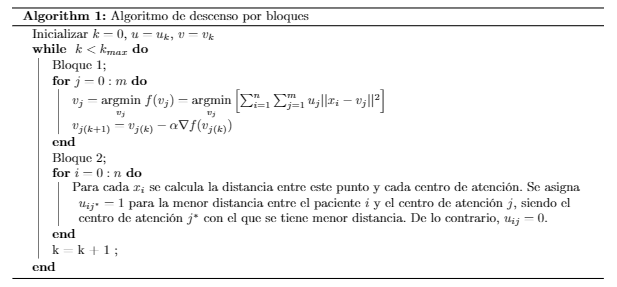

## Part 2 - Generate the infected individuals

We generate 200 pairs of coordinates, which represent the infected individuals ($n= 200$).
First, we generate a normal distribution, and then we encapsulate the result within a uniform distribution over the smallest rectangle $[a,b]$ x $[c,d]$ that gathers the infected individuals generated in the normal distribution.

In [2]:
n = 200
mu = 10
sigma = 10
X = np.random.normal(mu, sigma, size=(n, 2))

In [3]:
maximo = np.max(X)
minimo = np.min(X)
Xunif = np.random.uniform(minimo, maximo, size=(n,2))

## Part 3 - Implement Solution

In [4]:
# This method is used to create an n x m matrix where the rows represent the contagious individuals and the columns represent
# the medical centers, describing the distance between contagious individual i (row) and medical center j (column).
def create_distance_matrix(contagious, centers):
    # Each row is created as an empty list
    distances = []
    for i in range(len(contagious)):
        # The row is created as the iteration progresses
        distances.append([])
        for j in range(len(centers)):
            # In each row, the distance between contagious individual i and center j (the column) is calculated
            distances[i].append(np.sqrt((contagious[i][0] - centers[j][0])**2 + (contagious[i][1] - centers[j][1])**2))

    return distances


In [5]:
# Function that defines the U matrix.

# To minimize the problem when v_j is constant, it is sufficient to look at the distances between each contagious individual
# and each medical center. Therefore, a matrix indicating the distance between each contagious individual and medical center
# is traversed, and for contagious individual i, it is asked which of the three medical centers has the shortest distance. 
# In this position, a 1 is placed.

def block1(distance_matrix):
    rows, columns = np.shape(distance_matrix) 
    u_values = np.zeros((rows, columns))  
        
    for i in range(rows):
        smallest = distance_matrix[i][0] # The comparison reference point is defined (the first element of each row)
        medical_center = 0
        for j in range(columns):
            if distance_matrix[i][j] < smallest:
                smallest = distance_matrix[i][j] # Indicates in which column to place the 1
                medical_center = j
        
        u_values[i][medical_center] = 1 # 1 is placed in the position where there is a value smaller than the reference value
        
    return u_values

In [6]:
# Function that defines the objective function when the medical centers (variables v_j) are constants.
def objective_function(contagious, centers, U):
    
    distances = []
    resp = 0
    
    # The U matrix is traversed
    for i in range(len(contagious)):
        # In each row, a list is added to store the element of each column.
        distances.append([])
        for j in range(len(centers)):
            # The term representing the distance between each contagious individual and medical center j is calculated.
            dist = (((contagious[i][0] - centers[j][0])**2) + ((contagious[i][1] - centers[j][1])**2))
            # The complete term of the function is stored for each element of the U matrix.
            resp += U[i][j]*dist
            # The distance term (L2^2 norm) between contagious individual i and center j is added to the distances list.
            distances[i].append(dist)
            
    return [resp, distances]


In [7]:
# Function to find the gradient of the function when the u_ij are constants and the centers v_j are the variable.
def find_gradient(contagious, centers, U):
    gradient = []
    for j in range(len(centers)):
        # Variables for each component of the gradient
        var1 = 0
        var2 = 0
        for i in range(len(contagious)):
            var1 = var1 + -2*(contagious[i][0] - centers[j][0])*U[i][j]
            var2 = var2 + -2*(contagious[i][1] - centers[j][1])*U[i][j]
        gradient.append([var1,var2])
    # The gradient is converted to a NumPy array
    gradient = np.array(gradient)
    
    return gradient

In [8]:
# Gradient descent when u_ij are constant.
def gradient_descent(contagious, centers, U, a):
    k = 0
    error = 1
    solutions = [centers]
    
    while k < 1000 and error > 0.01:
        gradient = find_gradient(contagious, centers, U)
        v = [] # The current value of the medical center
        for i in range(len(gradient)):
            # The value of the medical center is updated
            v.append(centers[i] - (a*gradient[i]))
        # The error between the current and previous iteration is calculated.
        error = abs(objective_function(contagious, v, U)[0] - objective_function(contagious, centers, U)[0])
        centers = v.copy()
        solutions.append(centers) # Contains the history of the position of the medical center
        k += 1
        
    return [centers, solutions]


In [9]:
# Block descent algorithm implementation
def block_descent(contagious, centers, a):
    it = 0 # iteration
    tray = [] # algorithm trajectory
    dif = 1000 # variable for the stopping condition
    u_history = [] # u variable history
    epsilon = 0.000001
    
    
    while dif > epsilon and it < 1000:
        dist = create_distance_matrix(contagious, centers) # The distance matrix between each contagious and each medical center is created
        U = block1(dist) # The respective U matrix is ​​generated (the problem is minimized with v_j constant)
        u_history.append(U) # The value of the U matrix is ​​added for each iteration
        V1 = gradient_descent(contagious, centers, U, a)[0] # The value of the v_j variable (medical center) is calculated
        dif = np.abs(objective_function(contagious, V1, U)[0] - objective_function(contagious, centers, U)[0]) # error for the stopping condition
        centers = V1.copy() 
        tray.append(centers) # The current position of each medical center is saved
        it += 1
        
    return [centers, tray, U, u_history]


### Guidelines

Suppose you have access to $m = 3$ care centers. Implement the solution to the optimization problem stated in part 1 for the normal and uniform distributions proposed in part 2. For each execution, use 2 different initial points and two different values of $\alpha$ (of different orders of magnitude), where $\alpha$ is the learning rate in the subproblem responsible for placing the centers in the best possible position with respect to their assigned infected individuals.

Show for each of the above executions of the block coordinate descent method:

- The trajectory of the objective function value, i.e., plot the objective function vs. iteration
- The trajectory of the position of the centers $v_j$ in a two-dimensional space. On the same graph, plot the location of the infected individuals. Each map contains the care centers identified with a different color each. Plot each infected individual sharing the color of the center to which they are assigned at the end of the algorithm.


In [10]:
# Initial values
n = 200 # Number of infected people
m = 3 # Number of medical centers

# Different values of alpha
a = 10**-6
a1 = 10**-4

# Different initial positions of medical centers
Vinit = np.array([[5,1],[0,2],[8,9]])
Vinit1 = np.array([[3,5],[11,0],[6,2]])


### Trajectory plots:


#### With X (infected individuals) following a normal distribution with mean $\mu = 10$ and standard deviation $\sigma = 10$


**1)** With $\alpha = 10^{-6}$ and $V_{initial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$


In [11]:
resXVinita = block_descent(X, Vinit, a)

**a)** Objective function vs. iteration

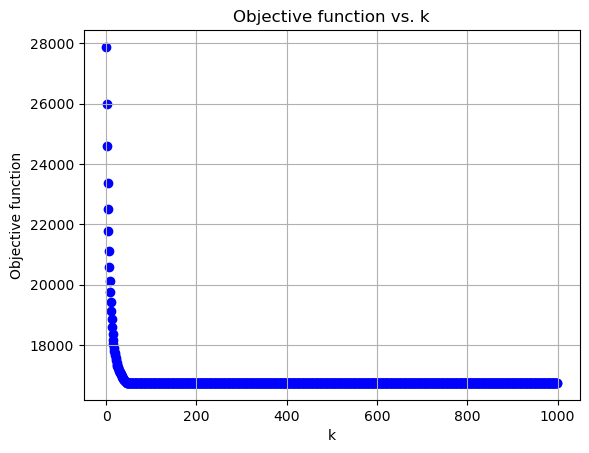

In [12]:
values = []
k = 0
iterations = []

for i in range(len(resXVinita[1])):
    values.append(objective_function(X, resXVinita[1][i], resXVinita[3][i])[0])
    iterations.append(k)
    k = k + 1 

for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective function')
plt.title('Objective function vs. k')
plt.show()

**b)** Trajectory of the medical centers

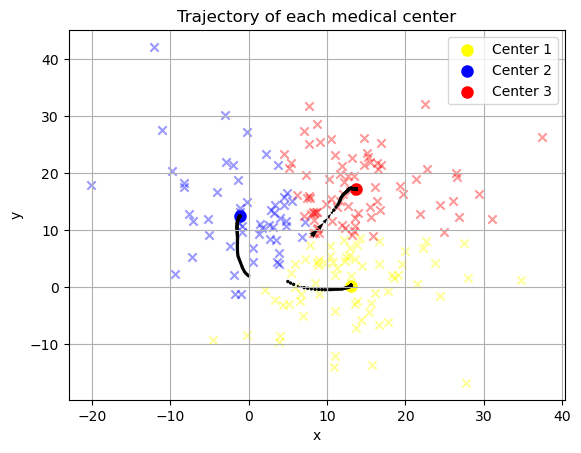

In [13]:
for i in range(n):
    if resXVinita[2][i][0] == 1:
        plt.scatter(X[i][0], X[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXVinita[2][i][1] == 1:
        plt.scatter(X[i][0], X[i][1], c='blue', marker='x', alpha=0.4)
    elif resXVinita[2][i][2] == 1:
        plt.scatter(X[i][0], X[i][1], c='red', marker='x', alpha=0.4)

aux = resXVinita[0]
plt.scatter(aux[0][0], aux[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(aux[1][0], aux[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(aux[2][0], aux[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

aux = Vinit.copy() # Initial position of medical centers
for element in resXVinita[1]: # Trajectory
    plt.quiver(aux[0][0], aux[0][1], element[0][0] - aux[0][0], element[0][1] - aux[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0], aux[1][1], element[1][0] - aux[1][0], element[1][1] - aux[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0], aux[2][1], element[2][0] - aux[2][0], element[2][1] - aux[2][1], angles='xy', scale_units='xy', scale=1)
    aux = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

**2)** With $\alpha = 10^{-4}$ and $V_{initial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [14]:
resXVinita1 = block_descent(X, Vinit, a1)

**a)** Objective function vs. iteration

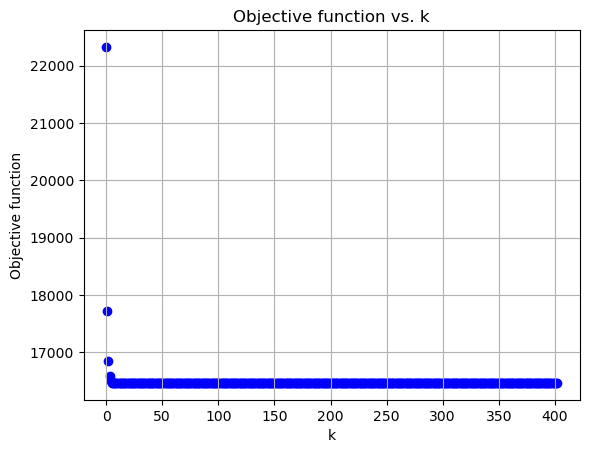

In [15]:
values = []
k = 0
iterations = []

for i in range(len(resXVinita1[1])):
    values.append(objective_function(X, resXVinita1[1][i], resXVinita1[3][i])[0])
    iterations.append(k)
    k = k + 1 
for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective function')
plt.title('Objective function vs. k')
plt.show()

**b)** Trajectory of the medical centers

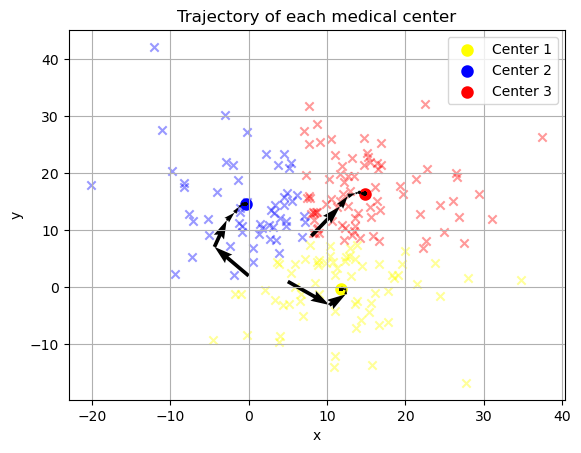

In [16]:
valores = []
k = 0
iterations = []

for i in range(n):
    if resXVinita1[2][i][0] == 1:
        plt.scatter(X[i][0], X[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXVinita1[2][i][1] == 1:
        plt.scatter(X[i][0], X[i][1], c='blue', marker='x', alpha=0.4)
    elif resXVinita1[2][i][2] == 1:
        plt.scatter(X[i][0], X[i][1], c='red', marker='x', alpha=0.4)

initial_pos = resXVinita1[0]
plt.scatter(initial_pos[0][0], initial_pos[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(initial_pos[1][0], initial_pos[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(initial_pos[2][0], initial_pos[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

initial_pos_copy = Vinit.copy() # Initial position of the medical centers
for element in resXVinita1[1]: # Path
    plt.quiver(initial_pos_copy[0][0], initial_pos_copy[0][1], element[0][0] - initial_pos_copy[0][0], element[0][1] - initial_pos_copy[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(initial_pos_copy[1][0], initial_pos_copy[1][1], element[1][0] - initial_pos_copy[1][0], element[1][1] - initial_pos_copy[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(initial_pos_copy[2][0], initial_pos_copy[2][1], element[2][0] - initial_pos_copy[2][0], element[2][1] - initial_pos_copy[2][1], angles='xy', scale_units='xy', scale=1)
    initial_pos_copy = element


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

**3)** With $\alpha = 10^{-6}$ and $V_{initial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [17]:
resXVinit1a = block_descent(X, Vinit1, a)

**a)** Objective function vs. iteration

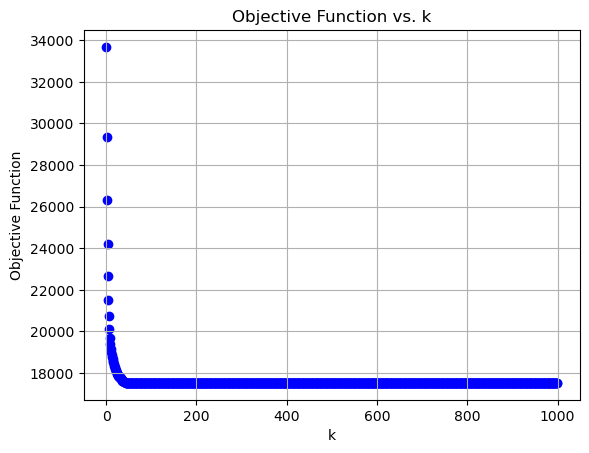

In [18]:
values = []
k = 0
iterations = []

for i in range(len(resXVinit1a[1])):
    values.append(objective_function(X, resXVinit1a[1][i], resXVinit1a[3][i])[0])
    iterations.append(k)
    k += 1 

for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective Function')
plt.title('Objective Function vs. k')
plt.show()

**b)** Trajectory of the medical centers

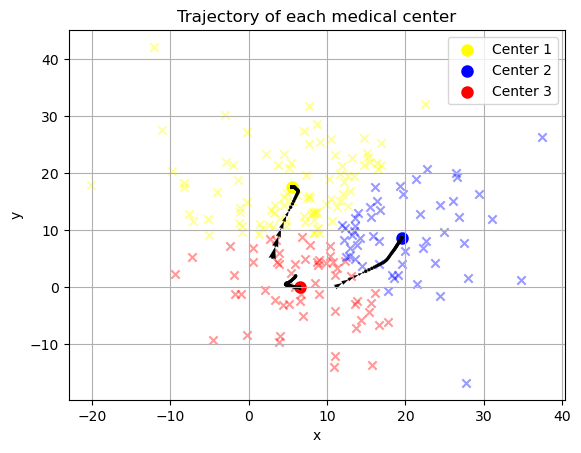

In [19]:
values = []
k = 0
iterations = []

for i in range(n):
    if resXVinit1a[2][i][0] == 1:
        plt.scatter(X[i][0], X[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXVinit1a[2][i][1] == 1:
        plt.scatter(X[i][0], X[i][1], c='blue', marker='x', alpha=0.4)
    elif resXVinit1a[2][i][2] == 1:
        plt.scatter(X[i][0], X[i][1], c='red', marker='x', alpha=0.4)

centers = resXVinit1a[0]
plt.scatter(centers[0][0], centers[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(centers[1][0], centers[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(centers[2][0], centers[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

initial_positions = Vinit1.copy()  # Initial positions of the medical centers
for element in resXVinit1a[1]:  # Trajectory
    plt.quiver(initial_positions[0][0], initial_positions[0][1], element[0][0] - initial_positions[0][0], element[0][1] - initial_positions[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(initial_positions[1][0], initial_positions[1][1], element[1][0] - initial_positions[1][0], element[1][1] - initial_positions[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(initial_positions[2][0], initial_positions[2][1], element[2][0] - initial_positions[2][0], element[2][1] - initial_positions[2][1], angles='xy', scale_units='xy', scale=1)
    initial_positions = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

**4)** With $\alpha = 10^{-4}$ and $V_{initial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [20]:
resXVinit1a1 = block_descent(X, Vinit1, a1)

**a)** Objective function vs. iteration

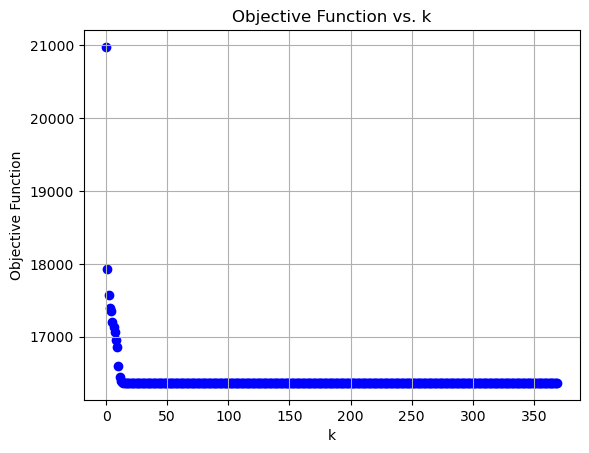

In [21]:
values = []
k = 0
iterations = []

for i in range(len(resXVinit1a1[1])):
    values.append(objective_function(X, resXVinit1a1[1][i], resXVinit1a1[3][i])[0])
    iterations.append(k)
    k = k + 1 
for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective Function')
plt.title('Objective Function vs. k')
plt.show()

**b)** Trajectory of the medical centers

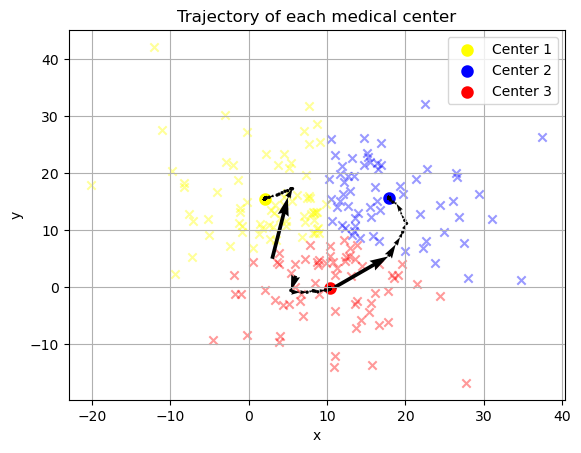

In [22]:
values = []
k = 0
iterations = []

for i in range(n):
    if resXVinit1a1[2][i][0] == 1:
        plt.scatter(X[i][0], X[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXVinit1a1[2][i][1] == 1:
        plt.scatter(X[i][0], X[i][1], c='blue', marker='x', alpha=0.4)
    elif resXVinit1a1[2][i][2] == 1:
        plt.scatter(X[i][0], X[i][1], c='red', marker='x', alpha=0.4)

aux = resXVinit1a1[0]
plt.scatter(aux[0][0], aux[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(aux[1][0], aux[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(aux[2][0], aux[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

aux = Vinit1.copy()  # Initial position of the medical centers
for element in resXVinit1a1[1]:  # Path
    plt.quiver(aux[0][0], aux[0][1], element[0][0] - aux[0][0], element[0][1] - aux[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0], aux[1][1], element[1][0] - aux[1][0], element[1][1] - aux[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0], aux[2][1], element[2][0] - aux[2][0], element[2][1] - aux[2][1], angles='xy', scale_units='xy', scale=1)
    aux = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

#### With X (infected individuals) following a uniform distribution in the rectangle [a, b] × [c, d] smaller than the smallest rectangle enclosing all infected individuals generated by the normal distribution

**1)** With $\alpha = 10^{-6}$ and $V_{initial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [23]:
resXUVinita = block_descent(Xunif, Vinit, a)

**a)** Objective function vs. iteration

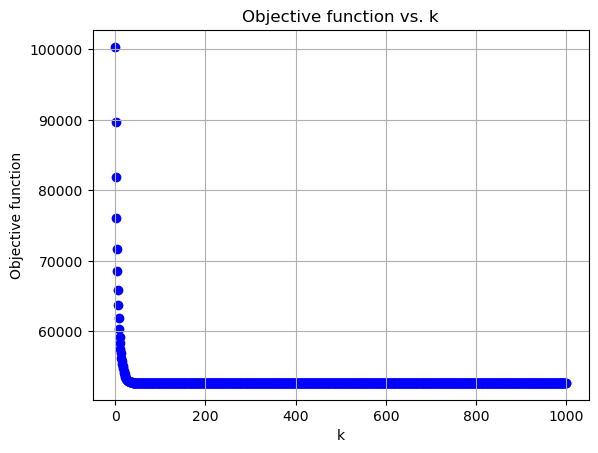

In [24]:
values = []
k = 0
iterations = []

for i in range(len(resXUVinita[1])):
    values.append(objective_function(Xunif, resXUVinita[1][i], resXUVinita[3][i])[0])
    iterations.append(k)
    k += 1 

for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective function')
plt.title('Objective function vs. k')
plt.show()

**b)** Trajectory of the medical centers

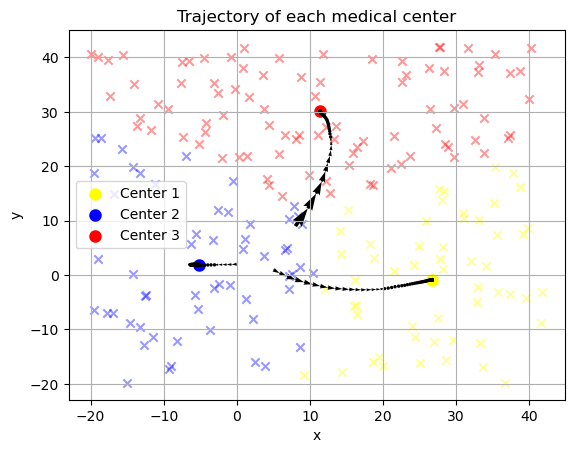

In [25]:
for i in range(n):
    if resXUVinita[2][i][0] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXUVinita[2][i][1] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='blue', marker='x', alpha=0.4)
    elif resXUVinita[2][i][2] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='red', marker='x', alpha=0.4)

aux = resXUVinita[0]
plt.scatter(aux[0][0], aux[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(aux[1][0], aux[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(aux[2][0], aux[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

aux = Vinit.copy() # Initial position of the medical centers
for element in resXUVinita[1]: # Trajectory
    plt.quiver(aux[0][0], aux[0][1], element[0][0] - aux[0][0], element[0][1] - aux[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0], aux[1][1], element[1][0] - aux[1][0], element[1][1] - aux[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0], aux[2][1], element[2][0] - aux[2][0], element[2][1] - aux[2][1], angles='xy', scale_units='xy', scale=1)
    aux = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

**2)** With $\alpha = 10^{-4}$ and $V_{initial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [26]:
resXUVinita1 = block_descent(Xunif, Vinit, a1)

**a)** Objective function vs. iteration

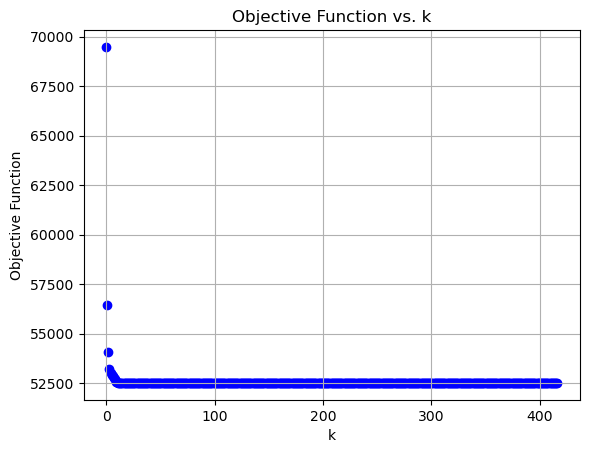

In [27]:
values = []
k = 0
iterations = []

for i in range(len(resXUVinita1[1])):
    values.append(objective_function(Xunif, resXUVinita1[1][i], resXUVinita1[3][i])[0])
    iterations.append(k)
    k = k + 1 

for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective Function')
plt.title('Objective Function vs. k')
plt.show()

**b)** Trajectory of the medical centers

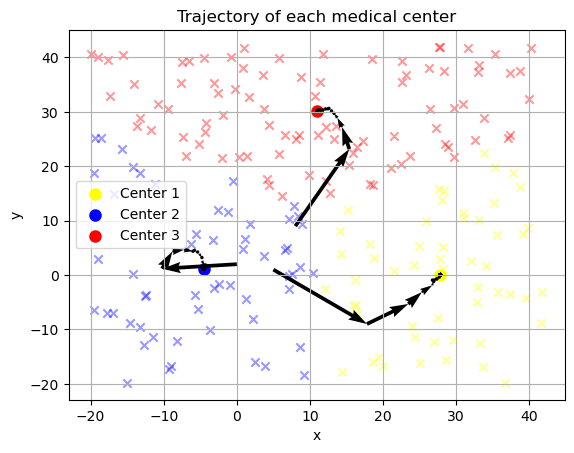

In [28]:
for i in range(n):
    if resXUVinita1[2][i][0] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXUVinita1[2][i][1] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='blue', marker='x', alpha=0.4)
    elif resXUVinita1[2][i][2] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='red', marker='x', alpha=0.4)

aux = resXUVinita1[0]
plt.scatter(aux[0][0], aux[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(aux[1][0], aux[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(aux[2][0], aux[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

aux = Vinit.copy()  # Initial position of medical centers
for element in resXUVinita1[1]:  # Path
    plt.quiver(aux[0][0], aux[0][1], element[0][0] - aux[0][0], element[0][1] - aux[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0], aux[1][1], element[1][0] - aux[1][0], element[1][1] - aux[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0], aux[2][1], element[2][0] - aux[2][0], element[2][1] - aux[2][1], angles='xy', scale_units='xy', scale=1)
    aux = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()


**3)** With $\alpha = 10^{-6}$ and $V_{initial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [29]:
resXUVinit1a = block_descent(Xunif, Vinit1, a)

**a)** Objective function vs. iteration

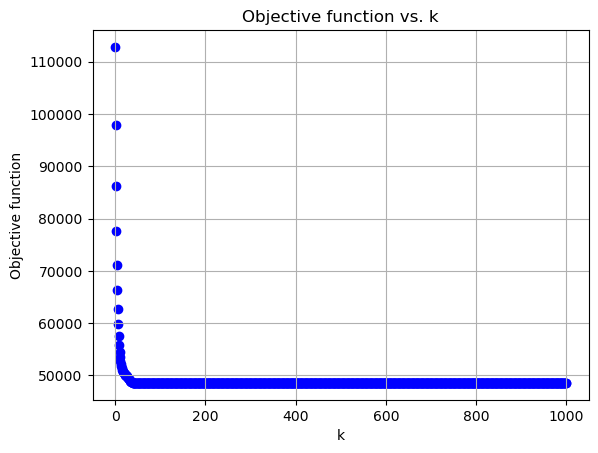

In [30]:
values = []
k = 0
iterations = []

for i in range(len(resXUVinit1a[1])):
    values.append(objective_function(Xunif, resXUVinit1a[1][i], resXUVinit1a[3][i])[0])
    iterations.append(k)
    k = k + 1 

for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective function')
plt.title('Objective function vs. k')
plt.show()

**b)** Trajectory of the medical centers

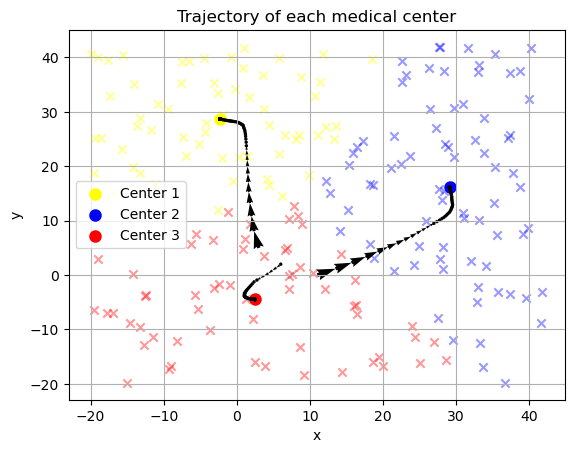

In [31]:
for i in range(n):
    if resXUVinit1a[2][i][0] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXUVinit1a[2][i][1] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='blue', marker='x', alpha=0.4)
    elif resXUVinit1a[2][i][2] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='red', marker='x', alpha=0.4)

aux = resXUVinit1a[0]
plt.scatter(aux[0][0], aux[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(aux[1][0], aux[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(aux[2][0], aux[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

aux = Vinit1.copy() # Initial position of medical centers
for element in resXUVinit1a[1]: # Path
    plt.quiver(aux[0][0], aux[0][1], element[0][0] - aux[0][0], element[0][1] - aux[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0], aux[1][1], element[1][0] - aux[1][0], element[1][1] - aux[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0], aux[2][1], element[2][0] - aux[2][0], element[2][1] - aux[2][1], angles='xy', scale_units='xy', scale=1)
    aux = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

**4)** With $\alpha = 10^{-4}$ and $V_{initial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [32]:
resXUVinit1a1 = block_descent(Xunif, Vinit1, a1)

**a)** Objective function vs. iteration

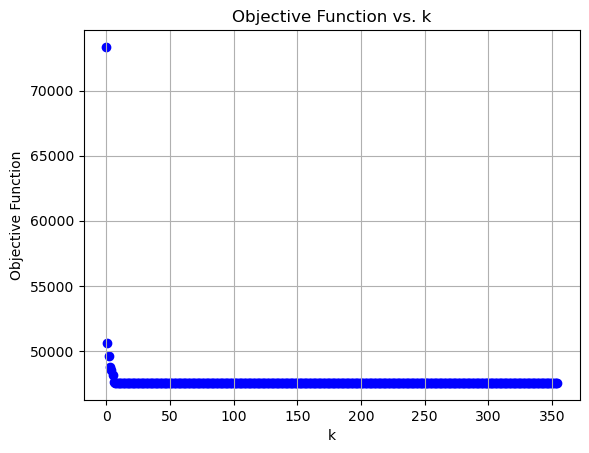

In [33]:
values = []
k = 0
iterations = []

for i in range(len(resXUVinit1a1[1])):
    values.append(objective_function(Xunif, resXUVinit1a1[1][i], resXUVinit1a1[3][i])[0])
    iterations.append(k)
    k = k + 1 

for i in range(len(values)):
    plt.scatter(iterations[i], values[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Objective Function')
plt.title('Objective Function vs. k')
plt.show()

**b)** Trajectory of the medical centers

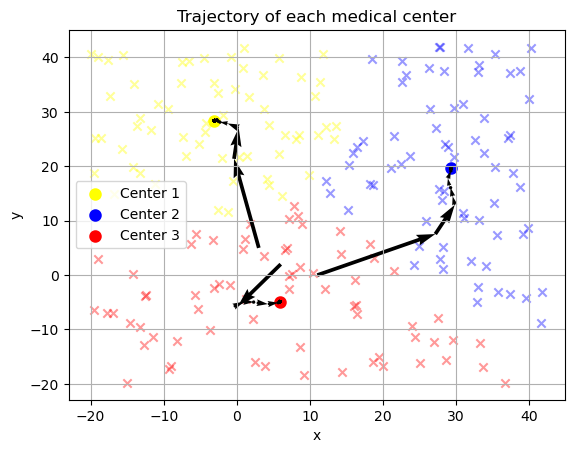

In [34]:
for i in range(n):
    if resXUVinit1a1[2][i][0] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='yellow', marker='x', alpha=0.4)
    elif resXUVinit1a1[2][i][1] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='blue', marker='x', alpha=0.4)
    elif resXUVinit1a1[2][i][2] == 1:
        plt.scatter(Xunif[i][0], Xunif[i][1], c='red', marker='x', alpha=0.4)

aux = resXUVinit1a1[0]
plt.scatter(aux[0][0], aux[0][1], c='yellow', marker='o', linewidths=3, alpha=1, label="Center 1")
plt.scatter(aux[1][0], aux[1][1], c='blue', marker='o', linewidths=3, alpha=1, label="Center 2")
plt.scatter(aux[2][0], aux[2][1], c='red', marker='o', linewidths=3, alpha=1, label="Center 3")

plt.legend() 

aux = Vinit1.copy() # Initial position of medical centers
for element in resXUVinit1a1[1]: # Trajectory
    plt.quiver(aux[0][0], aux[0][1], element[0][0] - aux[0][0], element[0][1] - aux[0][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0], aux[1][1], element[1][0] - aux[1][0], element[1][1] - aux[1][1], angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0], aux[2][1], element[2][0] - aux[2][0], element[2][1] - aux[2][1], angles='xy', scale_units='xy', scale=1)
    aux = element

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trajectory of each medical center')
plt.show()

## Part 4 - Analytical Solution

### Analytical solution block 1 ($u$ constant)

$\nabla f(v)=0$ \
$-2u_{ij}||x_i-v_j||=0$ \
$v_j = x_i$

### Analytical solution block 2 ($v$ constant)

$\mathcal{L}(u;\lambda)=\sum_{i=1}^n\sum_{j=1}^m u_{ij}^2||x_i-v_j||^2+\lambda(\sum_{j=1}^mu_{ij}-1)$ \

$\nabla \mathcal{L}(u;\lambda) = 2u_{ij}||x_i-v_j||^2 + \lambda = 0$ \

$u_{ij}=\frac{-\lambda}{2||x_i-v_j||^2}$ \
$\lambda=-2u_{ij}||x_i-v_j||^2$

Now, the constraint for the $u_{ij}$ is used to find an expression for $\lambda$.

$\sum_{j=1}^m u_{ij}=\sum_{j=1}^m \frac{-\lambda}{2||x_i-v_j||^2} = 1$ \
$\lambda = \frac{-1}{\sum_{j=1}^m \frac{1}{2||x_i-v_j||^2}} $

With this expression, $u_{ij}$ is found:

$u_{ij}=\frac{1}{\sum_{j=1}^m 2||x_i-v_j||^2 (2||x_i-v_j||^2)}$

## Part 5 - Analyze the results

From the obtained results, it is evident that the smaller the $\alpha$, the smaller the step between the objective function value in each iteration, as observed in the objective function vs. iteration plots. Similarly, this happens with the location of the medical centers, as the $\alpha$ increases, the steps between iterations become larger.

On the other hand, it was observed that for large values of $\alpha$, in some cases, the algorithm diverged if $X$ was normally distributed, while this did not happen if it was uniformly distributed.

Finally, it can be noticed that the distribution of the infected individuals significantly affects the final value of the objective function. When the distribution is normal, this value is lower than when the distribution is uniform. This is because with the normal distribution, most infected individuals are grouped near the mean, while with the uniform distribution, the infected individuals are more dispersed. This causes the distances between the infected individuals and the corresponding medical centers to be greater, increasing the value of the objective function.
